In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

/home/cheko/mambaforge/envs/myenv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
outcomes = pd.read_excel('BMAC_outcomes w pain scores.xlsx', index_col=0)

In [3]:
valid_outcome_ids = {}
to_keep = []
class_mapper = {'Y': 1, 'N': 0}
for n, i in outcomes.iterrows():
    if i['Responder (Y/N)'] in ['Y', 'N']:
        valid_outcome_ids[i['Donor ID']] = [i['Donor ID'], class_mapper[i['Responder (Y/N)']], i['change VAS'], i['change KOOS'], i['VAS baseline'], i['VAS 12 months'], i['KOOS pain baseline'], i['KOOS pain 12 months']]
#outcomes = outcomes.iloc[to_keep, : ]


In [4]:
outcomes = [valid_outcome_ids[x] for x in valid_outcome_ids]
df_outcomes = pd.DataFrame(outcomes, columns = ["donor ID", "responder", "cVAS", "cKOOS", "VAS baseline", "VAS 12", "KOOS baseline", "KOOS 12"])
df_outcomes

,donor ID,responder,cVAS,cKOOS,VAS baseline,VAS 12,KOOS baseline,KOOS 12
0,01-004,1,-38.0,20.0,45.0,7.0,58.0,78.0
1,01-016,1,-51.0,33.0,91.0,40.0,25.0,58.0
2,01-022,1,0.0,-3.0,50.0,50.0,61.0,58.0
3,01-041,0,2.0,11.0,48.0,50.0,53.0,64.0
4,01-054,1,-44.0,48.0,50.0,6.0,44.0,92.0
5,01-061,1,-26.0,36.0,70.0,44.0,33.0,69.0
6,01-101,1,-20.0,22.0,50.0,30.0,53.0,75.0
7,01-102,0,-10.0,3.0,90.0,80.0,33.0,36.0
8,01-118,0,-20.0,11.0,80.0,60.0,36.0,47.0
9,01-136,1,-35.0,23.0,56.0,21.0,58.0,81.0


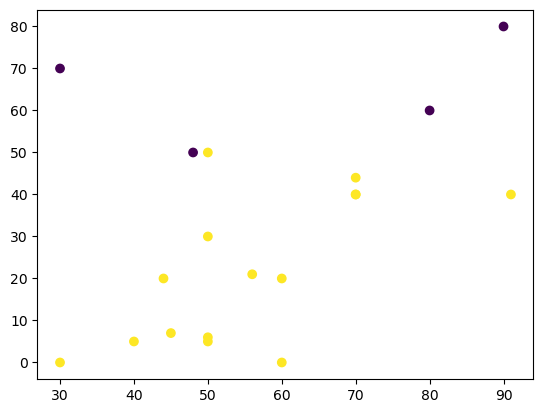

In [5]:
plt.scatter(df_outcomes["VAS baseline"], df_outcomes["VAS 12"], c = df_outcomes['responder'])

In [6]:
df_noout = df_outcomes.iloc[list(set(list(range(19))).difference([17, 1]))]

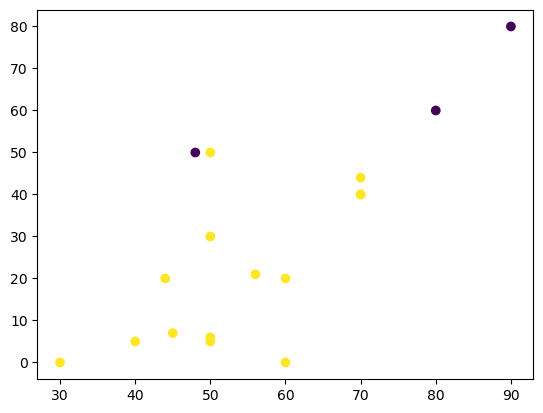

In [7]:
plt.scatter(df_noout["VAS baseline"], df_noout["VAS 12"], c = df_noout['responder'])

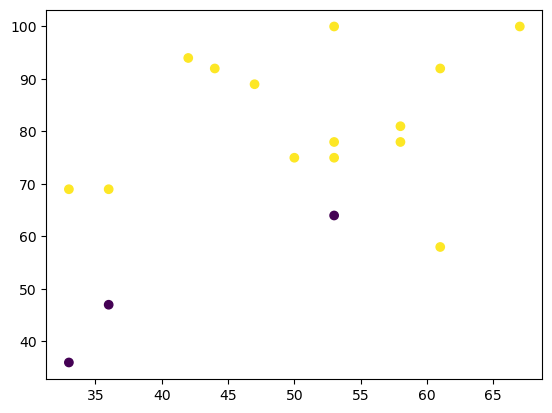

In [8]:
plt.scatter(df_noout["KOOS baseline"], df_noout["KOOS 12"], c = df_noout['responder'])

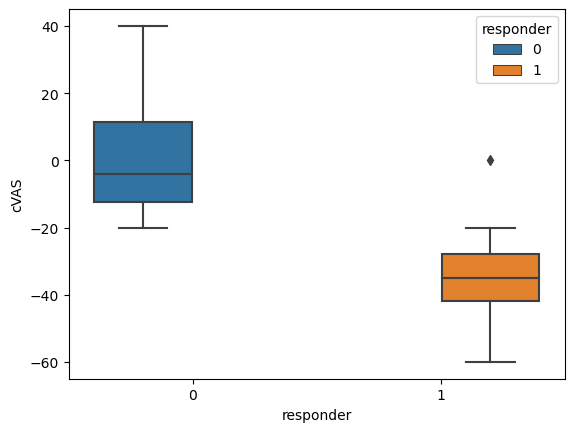

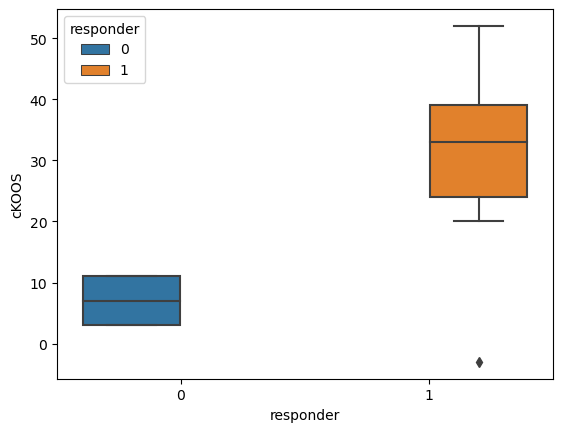

In [9]:
sns.boxplot(df_outcomes, x='responder', y='cVAS', hue='responder')
plt.show()

sns.boxplot(df_outcomes, x='responder', y='cKOOS', hue='responder')
plt.show()

In [10]:
data = pd.read_excel('BMAC.xlsx', sheet_name = 'On-chip ctrl NORM')

In [11]:
rows = []
classes = []
vas = []
koos = []
for n, i in data.iterrows():
    if i['Samples'][-1] == "1" and i['Samples'].split()[0] in list(valid_outcome_ids.keys()):
        rows.append(n)
        classes.append(valid_outcome_ids[i['Donor ID']][0])
        vas.append(valid_outcome_ids[i['Donor ID']][1])
        koos.append(valid_outcome_ids[i['Donor ID']][2])
        

In [12]:
features = ["TNF-alpha" ,"IL-6" ,"PD-L1" ,"MMP-3" ,"IL-8" ,"MMP-1" ,"FAP" ,"CCL2/MCP-1" ,"VEGF" ,"IFN-gamma" ,"IL-17E" ,"MMP-13" ,"HGF" ,"CCL3/MIP-1 alpha" ,"IL-17" ,"FGF basic" ,"M-CSF" ,"CXCL9/MIG" ,"IL-12 p70" ,"VCAM-1" ,"ICAM-1" ,"TNF R1" ,"TIMP-1" ,"IGFBP-rp1"]

In [13]:
data = data.iloc[rows, :]
data = data.loc[ : , features]

# KOOS Modelling

In [14]:
outcomes = pd.read_excel('BMAC_outcomes w pain scores.xlsx', index_col=0)
valid_outcome_ids = {}
to_keep = []
class_mapper = {'Y': 1, 'N': 0}
for n, i in outcomes.iterrows():
    if i['Responder (Y/N)'] in ['Y', 'N']:
        if i['Donor ID'] != "02-089" and i['Donor ID'] != "01-016":
            valid_outcome_ids[i['Donor ID']] = [i['Donor ID'], class_mapper[i['Responder (Y/N)']], i['change VAS'], i['change KOOS'], i['VAS baseline'], i['VAS 12 months'], i['KOOS pain baseline'], i['KOOS pain 12 months']]
#outcomes = outcomes.iloc[to_keep, : ]


In [15]:
features = ["TNF-alpha" ,"IL-6" ,"PD-L1" ,"MMP-3" ,"IL-8" ,"MMP-1" ,"FAP" ,"CCL2/MCP-1" ,"VEGF" ,"IFN-gamma" ,"IL-17E" ,"MMP-13" ,"HGF" ,"CCL3/MIP-1 alpha" ,"IL-17" ,"FGF basic" ,"M-CSF" ,"CXCL9/MIG" ,"IL-12 p70" ,"VCAM-1" ,"ICAM-1" ,"TNF R1" ,"TIMP-1" ,"IGFBP-rp1"]

for method in ['On-chip ctrl NORM', 'On-chip simSF NORM', '2D simSF NORM']:
    data = pd.read_excel('BMAC.xlsx', sheet_name = method)
    rows = []
    classes = []
    vas = []
    koos = []
    for n, i in data.iterrows():
        if i['Samples'][-1] == "1" and i['Samples'].split()[0] in list(valid_outcome_ids.keys()):
            rows.append(n)
            classes.append(valid_outcome_ids[i['Donor ID']][1])
            vas.append(valid_outcome_ids[i['Donor ID']][2])
            koos.append(valid_outcome_ids[i['Donor ID']][3])
    data = data.iloc[rows, :]
    data = data.loc[ : , features]
    data = StandardScaler().fit_transform(data)
    koos = StandardScaler().fit_transform(np.array(koos).reshape(-1, 1))
    data = np.array(data)
    classes = np.array(classes)
    folds = 3
    repeats = 150
    mses = []
    rskf = RepeatedStratifiedKFold(n_splits= folds, n_repeats= repeats, random_state=36851234)
    for n, (train_index, test_index) in enumerate(rskf.split(data, classes)):
        X_train, X_test = [data[i] for i in train_index], [data[i] for i in test_index]
        y_train, y_test = [koos[i] for i in train_index], [koos[i] for i in test_index]
        model = Lasso()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mses.append(mean_squared_error(y_test, y_pred))
    # plt.show()
    print(f"{method} : 3 Fold 150 Repeats MSE", np.mean(mses))



On-chip ctrl NORM : 3 Fold 150 Repeats MSE 1.1064306222528262
On-chip simSF NORM : 3 Fold 150 Repeats MSE 1.1064306222528262
2D simSF NORM : 3 Fold 150 Repeats MSE 1.1064866298585503


# VAS Modelling

In [19]:
outcomes = pd.read_excel('BMAC_outcomes w pain scores.xlsx', index_col=0)

In [20]:
valid_outcome_ids = {}
to_keep = []
class_mapper = {'Y': 1, 'N': 0}
for n, i in outcomes.iterrows():
    if i['Responder (Y/N)'] in ['Y', 'N']:
        if i['Donor ID'] != "02-089" and i['Donor ID'] != "01-016":
            valid_outcome_ids[i['Donor ID']] = [class_mapper[i['Responder (Y/N)']], i['change VAS'], i['change KOOS']]
#outcomes = outcomes.iloc[to_keep, : ]


In [21]:
features = ["TNF-alpha" ,"IL-6" ,"PD-L1" ,"MMP-3" ,"IL-8" ,"MMP-1" ,"FAP" ,"CCL2/MCP-1" ,"VEGF" ,"IFN-gamma" ,"IL-17E" ,"MMP-13" ,"HGF" ,"CCL3/MIP-1 alpha" ,"IL-17" ,"FGF basic" ,"M-CSF" ,"CXCL9/MIG" ,"IL-12 p70" ,"VCAM-1" ,"ICAM-1" ,"TNF R1" ,"TIMP-1" ,"IGFBP-rp1"]

for method in ['On-chip ctrl NORM', 'On-chip simSF NORM', '2D simSF NORM']:
    data = pd.read_excel('BMAC.xlsx', sheet_name = method)
    rows = []
    classes = []
    vas = []
    koos = []
    for n, i in data.iterrows():
        if i['Samples'][-1] == "1" and i['Samples'].split()[0] in list(valid_outcome_ids.keys()):
            rows.append(n)
            classes.append(valid_outcome_ids[i['Donor ID']][0])
            vas.append(valid_outcome_ids[i['Donor ID']][1])
            koos.append(valid_outcome_ids[i['Donor ID']][2])
    data = data.iloc[rows, :]
    data = data.loc[ : , features]
    data[:] = StandardScaler().fit_transform(data)
    vas[:] = StandardScaler().fit_transform(np.array(vas).reshape(-1, 1))
    vas = np.array(vas)
    folds = 3
    repeats = 150
    mses = []
    rskf = RepeatedStratifiedKFold(n_splits= folds, n_repeats= repeats, random_state=36851234)
    data = data.reset_index(drop=True)
    for n, (train_index, test_index) in enumerate(rskf.split(data, classes)):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = vas[train_index], vas[test_index]
        correlation = X_train.corrwith(pd.Series(y_train.flatten()))
        correlation_sorted = correlation.abs().sort_values(ascending=False)
        # Get top 5 most correlated columns
        top_corr_features = correlation_sorted.head(5).index.values
        model = Lasso()
        model.fit(X_train[top_corr_features], y_train)
        y_pred = model.predict(X_test[top_corr_features])
        mses.append(mean_squared_error(y_test, y_pred))
    # plt.show()
    print(f"{method} : 3 Fold 150 Repeats MSE", np.mean(mses))



On-chip ctrl NORM : 3 Fold 150 Repeats MSE 1.1129398073671493
On-chip simSF NORM : 3 Fold 150 Repeats MSE 1.1129398073671493
2D simSF NORM : 3 Fold 150 Repeats MSE 1.1129398073671493


# Modelling using topk most predictive and most correlated features

In [ ]:
data_method = []
features = ["TNF-alpha" ,"IL-6" ,"PD-L1" ,"MMP-3" ,"IL-8" ,"MMP-1" ,"FAP" ,"CCL2/MCP-1" ,"VEGF" ,"IFN-gamma" ,"IL-17E" ,"MMP-13" ,"HGF" ,"CCL3/MIP-1 alpha" ,"IL-17" ,"FGF basic" ,"M-CSF" ,"CXCL9/MIG" ,"IL-12 p70" ,"VCAM-1" ,"ICAM-1" ,"TNF R1" ,"TIMP-1" ,"IGFBP-rp1"]

for method in ['On-chip ctrl NORM', 'On-chip simSF NORM', '2D simSF NORM']:
    data = pd.read_excel('BMAC.xlsx', sheet_name = method)
    rows = []
    classes = []
    vas = []
    koos = []
    for n, i in data.iterrows():
        if i['Samples'][-1] == "1" and i['Samples'].split()[0] in list(valid_outcome_ids.keys()):
            rows.append(n)
            classes.append(valid_outcome_ids[i['Donor ID']][1])
            vas.append(valid_outcome_ids[i['Donor ID']][2])
            koos.append(valid_outcome_ids[i['Donor ID']][3])
    data = data.iloc[rows, :]
    data = data.loc[ : , features]
    data[:] = StandardScaler().fit_transform(data)
    data_method.append(data)
    koos = StandardScaler().fit_transform(np.array(koos).reshape(-1, 1))
    vas = StandardScaler().fit_transform(np.array(vas).reshape(-1, 1))

In [ ]:
from itertools import combinations

#normal
features = ["TNF-alpha" ,"IL-6" ,"PD-L1" ,"MMP-3" ,"IL-8" ,"MMP-1" ,"FAP" ,"CCL2/MCP-1" ,"VEGF" ,"IFN-gamma" ,"IL-17E" ,"MMP-13" ,"HGF" ,"CCL3/MIP-1 alpha" ,"IL-17" ,"FGF basic" ,"M-CSF" ,"CXCL9/MIG" ,"IL-12 p70" ,"VCAM-1" ,"ICAM-1" ,"TNF R1" ,"TIMP-1" ,"IGFBP-rp1"]
from sklearn import linear_model
rows_koos = []
rows_vas = []
for k in range(3):
    k = k+1
    row_koos_temp = []
    row_koos_temp_feat = []
    row_vas_temp = []
    row_vas_temp_feat = []
    for feat in list(combinations(features, k)):
        temp1 = []
        temp1_feat = []
        temp2 = []
        temp2_feat = []
        feat = list(feat)
        for method in ['On-chip ctrl NORM', 'On-chip simSF NORM', '2D simSF NORM']:
            data = pd.read_excel('BMAC.xlsx', sheet_name = method)
            rows = []
            classes = []
            vas = []
            koos = []
            for n, i in data.iterrows():
                if i['Samples'][-1] == "1" and i['Samples'].split()[0] in list(valid_outcome_ids.keys()):
                    rows.append(n)
                    classes.append(valid_outcome_ids[i['Donor ID']][1])
                    vas.append(valid_outcome_ids[i['Donor ID']][2])
                    koos.append(valid_outcome_ids[i['Donor ID']][3])
            data = data.iloc[rows, :]
            data = data.loc[ : , feat]
            data[:] = StandardScaler().fit_transform(data)
            koos[:] = StandardScaler().fit_transform(np.array(koos).reshape(-1, 1))
            vas[:] = StandardScaler().fit_transform(np.array(vas).reshape(-1, 1))
            vas = np.array(vas)
            koos = np.array(koos)
            data = data.reset_index(drop=True)
            model = linear_model.LinearRegression()
            model.fit(data[feat], vas)
            temp1.append(model.score(data[feat], vas))
            temp1_feat.append(feat)
            model.fit(data[feat], koos)
            temp2.append(model.score(data[feat], koos))
            temp2_feat.append(feat)
        row_vas_temp.append(temp1)
        row_koos_temp.append(temp2)
        row_vas_temp_feat.append(temp1_feat)
        row_koos_temp_feat.append(temp2_feat)
    row_vas_temp = np.array(row_vas_temp)
    row_koos_temp = np.array(row_koos_temp)
    row_vas_temp_feat = np.array(row_vas_temp_feat)
    row_koos_temp_feat = np.array(row_koos_temp_feat)
    print(row_vas_temp_feat.shape)
    rows_vas.append([k, np.max(row_vas_temp[:, 0]), np.max(row_vas_temp[:, 1]), np.max(row_vas_temp[:, 2]), row_vas_temp_feat[np.argmax(row_vas_temp[:, 0])], row_vas_temp_feat[np.argmax(row_vas_temp[:, 1])], row_vas_temp_feat[np.argmax(row_vas_temp[:, 2])]])
    rows_koos.append([k, np.max(row_koos_temp[:, 0]), np.max(row_koos_temp[:, 1]), np.max(row_koos_temp[:, 2]), row_koos_temp_feat[np.argmax(row_koos_temp[:, 0])], row_koos_temp_feat[np.argmax(row_koos_temp[:, 1])], row_koos_temp_feat[np.argmax(row_koos_temp[:, 2])]])

(24, 3, 1)
(276, 3, 2)
(2024, 3, 3)


In [ ]:
df_topk_koos = pd.DataFrame(rows_koos, columns = ['k', 'On-chip ctrl NORM', 'On-chip simSF NORM', '2D simSF NORM', 'On-chip ctrl NORM Features', 'On-chip simSF NORM Features', '2D simSF NORM Features'])
df_topk_vas = pd.DataFrame(rows_vas, columns = ['k', 'On-chip ctrl NORM', 'On-chip simSF NORM', '2D simSF NORM', 'On-chip ctrl NORM Features', 'On-chip simSF NORM Features', '2D simSF NORM Features'])

In [ ]:
features = ["TNF-alpha" ,"IL-6" ,"PD-L1" ,"MMP-3" ,"IL-8" ,"MMP-1" ,"FAP" ,"CCL2/MCP-1" ,"VEGF" ,"IFN-gamma" ,"IL-17E" ,"MMP-13" ,"HGF" ,"CCL3/MIP-1 alpha" ,"IL-17" ,"FGF basic" ,"M-CSF" ,"CXCL9/MIG" ,"IL-12 p70" ,"VCAM-1" ,"ICAM-1" ,"TNF R1" ,"TIMP-1" ,"IGFBP-rp1"]
from sklearn import linear_model
rows_koos = []
rows_vas = []
for num in range(3):
    num = num+1
    temp1 = [num]
    temp2 = [num]
    for method in ['On-chip ctrl NORM', 'On-chip simSF NORM', '2D simSF NORM']:
        data = pd.read_excel('BMAC.xlsx', sheet_name = method)
        rows = []
        classes = []
        vas = []
        koos = []
        for n, i in data.iterrows():
            if i['Samples'][-1] == "1" and i['Samples'].split()[0] in list(valid_outcome_ids.keys()):
                rows.append(n)
                classes.append(valid_outcome_ids[i['Donor ID']][1])
                vas.append(valid_outcome_ids[i['Donor ID']][2])
                koos.append(valid_outcome_ids[i['Donor ID']][3])
        data = data.iloc[rows, :]
        data = data.loc[ : , features]
        data[:] = StandardScaler().fit_transform(data)
        koos[:] = StandardScaler().fit_transform(np.array(koos).reshape(-1, 1))
        vas[:] = StandardScaler().fit_transform(np.array(vas).reshape(-1, 1))
        vas = np.array(vas)
        koos = np.array(koos)
        data = data.reset_index(drop=True)
        correlation = data.corrwith(pd.Series(vas.flatten()), method="spearman")
        correlation_sorted = correlation.abs().sort_values(ascending=False)
        top_corr_features = correlation_sorted.head(num+1).index.values
        model = linear_model.LinearRegression()
        model.fit(data[top_corr_features], vas)
        y_pred = model.predict(data[top_corr_features])
        temp1.append(r2_score(vas, y_pred))
        correlation = data.corrwith(pd.Series(koos.flatten()), method="spearman")
        correlation_sorted = correlation.abs().sort_values(ascending=False)
        top_corr_features = correlation_sorted.head(num+1).index.values
        model.fit(data[top_corr_features], koos)
        y_pred = model.predict(data[top_corr_features])
        temp2.append(r2_score(koos, y_pred))
    rows_vas.append(temp1)
    rows_koos.append(temp2)
    print(rows_vas[-1])
    # print(num, temp1, temp2)
# print(np.mean(rows_vas, axis = 0))
# print(np.mean(rows_koos, axis = 0))

[1, 0.24051466043457548, 0.2705139035642219, 0.1560356856013264]
[2, 0.2803394768899926, 0.31133509731134357, 0.19443277538401482]
[3, 0.41508681026699934, 0.3158924068763619, 0.2684446454058459]


In [ ]:
df_corr_koos = pd.DataFrame(rows_koos, columns = ['k', 'On-chip ctrl NORM', 'On-chip simSF NORM', '2D simSF NORM'])
df_corr_vas = pd.DataFrame(rows_vas, columns = ['k', 'On-chip ctrl NORM', 'On-chip simSF NORM', '2D simSF NORM'])

In [ ]:
with pd.ExcelWriter('BMAC_corr_and_topk.xlsx') as writer:
    df_corr_koos.to_excel(writer, sheet_name='corr_koos', index=None)
    df_corr_vas.to_excel(writer, sheet_name='corr_vas', index=None)
    df_topk_koos.to_excel(writer, sheet_name='topk_koos', index=None)
    df_topk_vas.to_excel(writer, sheet_name='topk_vas', index=None)